In [1]:
using DelimitedFiles, StatsBase, Plots, Printf, ProgressMeter
include("../code/matrix_generator.jl")

valid_degrees (generic function with 2 methods)

## Define functions

In [2]:
cd("../code/lr_federico")

In [22]:
function run_c_code(N::Int, f1::Real, f2::Real, randseed::Int=1)
    writedlm("random.txt", randseed)
    command = `./lr_federico $N $f1 $f2`
    run(command)
end

run_c_code (generic function with 2 methods)

In [9]:
function readgraph(fn="./graph.txt")
    graph = readdlm(fn, Int)
    nfactors = size(graph,1)
    I = Int[]
    J = Int[]
    sizehint!(I, 3*nfactors)
    sizehint!(J, 3*nfactors)
    for i in 1:nfactors
        push!(I, graph[i,1], graph[i,1], graph[i,1])
        push!(J, graph[i,2], graph[i,3], graph[i,4])
    end
    H = sparse(I,J,trues(3*nfactors))
end

readgraph (generic function with 2 methods)

In [10]:
function readweights(fn="./weights.txt")
    weights = readdlm(fn)
    sizes = Int.(weights[:,1])
    hW,vW = weights[:,2], weights[:,3]
    sizes, hW, vW
end

readweights (generic function with 2 methods)

In [11]:
function leaf_removal(H::SparseMatrixCSC, Ht = sparse(H'))
    M, N = size(H)
    degs = vec(sum(H, dims=1))
    facts = trues(M)
    rowperm = Int32[]
    Q = Int32.(findall(degs .== 1))
    indep = Int32.(findall(degs .== 0))
    dep = Int32[]
    sizehint!(indep, N-M)
    sizehint!(dep, M)
    sizehint!(rowperm, M)
    while !isempty(Q)
        i = popfirst!(Q)
        degs[i] == 0 && continue
        push!(dep, i)
        ∂i = @view rowvals(H)[nzrange(H,i)]
        a = ∂i[findfirst(b->facts[b], ∂i)]
        facts[a] = false
        push!(rowperm, a) 
        for j in @view rowvals(Ht)[nzrange(Ht,a)]
            degs[j] -= 1
            if j != i
                if degs[j] == 0
                    push!(indep, j)
                elseif degs[j] == 1
                    push!(Q, j)
                end
            end
        end
    end
    all(degs .==  0) || @warn "non-empty core"
    rowperm, dep, indep
end

leaf_removal (generic function with 2 methods)

In [12]:
isuppertriang(H::SparseMatrixCSC) = all(rowvals(H)[last(nzrange(H,i))] == i for i = 1:size(H,1))
function echelonize(Hdep, Hindep_t)
    m = size(Hdep,1)
    @assert isuppertriang(Hdep)
    # Store the rows of the right part in a vector of sparse vectors
    R = [Hindep_t[:,r] for r in 1:m]
    # Loop over diagonal elements
    @inbounds for c in m:-1:2
        # Loop over the elements above H[c,c]
        for j in @view rowvals(Hdep)[nzrange(Hdep,c)[1:end-1]]
            R[j] .⊻= R[c]
        end
    end
    R
end
function echelonize_approx(Hdep, Hindep_t)
    m = size(Hdep,1)
    @assert isuppertriang(Hdep)
    # Store the rows of the right part in a vector of sparse vectors
    R = [Int.(Hindep_t[:,r]) for r in 1:m]
    # Loop over diagonal elements
    @inbounds for c in m:-1:2
        # Loop over the elements above H[c,c]
        for j in @view rowvals(Hdep)[nzrange(Hdep,c)[1:end-1]]
            R[j] .+= R[c]
        end
    end
    R
end

echelonize_approx (generic function with 1 method)

## Start

In [25]:
N = 10^6
f1 = 0.0
f2 = 1.0
randseed = 1234
run_c_code(N, f1, f2, randseed)

# rate = 0.333334



Process(`./lr_federico 1000000 0.0 1.0`, ProcessExited(0))

In [24]:
sizes1, hW1, vW1 = readweights();

In [14]:
hmin1=minimum(hW1[hW1.!=0])
vmin1=minimum(vW1[vW1.!=0]);

In [15]:
H = readgraph()
Ht = permutedims(H);

In [16]:
rowperm, dep, indep = leaf_removal(H,Ht)
Hdep, Hindep_t = H[rowperm,dep], Ht[indep,rowperm];

In [17]:
R2 = echelonize(Hdep, Hindep_t)
hist2 = fit(Histogram, sum.(R2), sizes1)
hW2 = [hist2.weights;0] ./ sum(hist2.weights)
hmin2=minimum(hW2[hW2.!=0]);

In [18]:
R3 = echelonize_approx(Hdep, Hindep_t)
hist3 = fit(Histogram, sum.(R3), sizes1)
hW3 = [hist3.weights;0] ./ sum(hist3.weights)
hmin3=minimum(hW3[hW3.!=0]);

In [19]:
hmin = minimum([hmin1, hmin2, hmin3]);

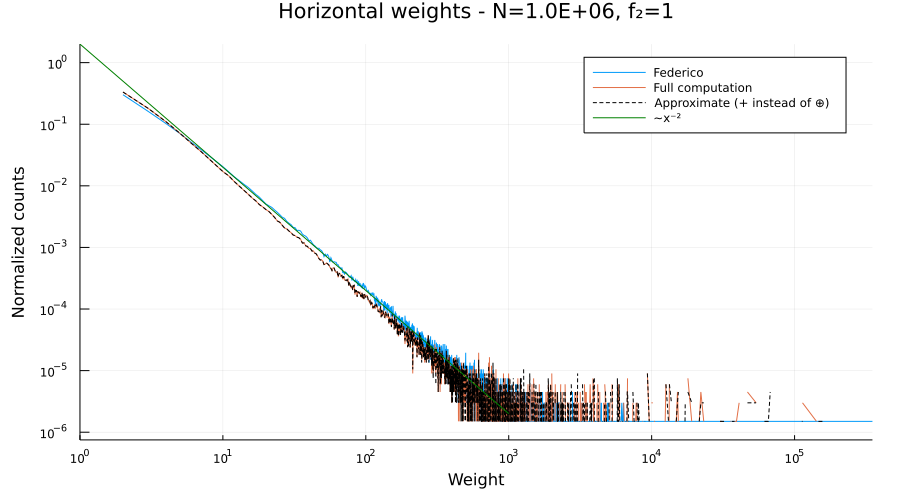

In [21]:
plh = plot(sizes1, hW1, xaxis=(:log10, (1,Inf)), yaxis=(:log10,(hmin/2,Inf)),label="Federico")
plot!(plh, sizes1, hW2, xaxis=(:log10, (1,Inf)), label="Full computation", style=:solid)
plot!(plh, sizes1, hW3, xaxis=(:log10, (1,Inf)), label="Approximate (+ instead of ⊕)", style=:dash, c=:black)
xrange = 10.0 .^ (0:0.1:3); plot!(plh, xrange, xrange .^ (-2) * 2, label="∼x⁻²", c=:green, lw=1)
plot(plh, size=(900,500), dpi=100, title=@sprintf("Horizontal weights - N=%.1E, f₂=1",size(H,2)), 
    xlabel="Weight", 
    ylabel="Normalized counts", margin=5*Plots.mm)